In [2]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_path = '../data/DATASET/train'
test_path = '../data/DATASET/test'

train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
)

In [3]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def train_epoch(model, loader, optimizer, loss_fn, device='cuda'):
    model.train()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        all_predictions.extend(output.argmax(1).cpu().detach().numpy())
        all_targets.extend(target.cpu().detach().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    
    return avg_loss, accuracy, f1

def evaluate_epoch(model, loader, loss_fn, device='cuda'):

    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = loss_fn(output, target)
            
            total_loss += loss.item()
            
            all_predictions.extend(output.argmax(1).cpu().detach().numpy())
            all_targets.extend(target.cpu().detach().numpy())
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    
    return avg_loss, accuracy, f1

In [4]:
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    print("Проверка данных:")
    print(f"Train loss: {history['train_loss']}")
    print(f"Test loss: {history['test_loss']}")
    print(f"Train acc: {history['train_acc']}")
    print(f"Test acc: {history['test_acc']}")
    print(f"Train f1: {history['train_f1']}")
    print(f"Test f1: {history['test_f1']}")

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.plot(epochs, history['train_loss'], label='Train Loss')
    ax1.plot(epochs, history['test_loss'], label='Test Loss')
    ax1.legend(); ax1.set_title('Loss')
    ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss')
    
    ax2.plot(epochs, history['train_acc'], label='Train Acc')
    ax2.plot(epochs, history['test_acc'], label='Test Acc')
    ax2.legend(); ax2.set_title('Accuracy')
    ax2.set_xlabel('Epochs'); ax2.set_ylabel('Accuracy')
    
    ax3.plot(epochs, history['train_f1'], label='Train F1')
    ax3.plot(epochs, history['test_f1'], label='Test F1')
    ax3.legend(); ax3.set_title('F1 Score')
    ax3.set_xlabel('Epochs'); ax3.set_ylabel('F1 Score')
    
    plt.yscale('log')
    plt.tight_layout()
    plt.show()


EPOCH 1/50
Epoch: 1, F1: 0.561

EPOCH 2/50
Epoch: 2, F1: 0.578

EPOCH 3/50
Epoch: 3, F1: 0.609

EPOCH 4/50

EPOCH 5/50
Epoch: 5, F1: 0.619

EPOCH 6/50
Epoch: 6, F1: 0.627

EPOCH 7/50

EPOCH 8/50

EPOCH 9/50

EPOCH 10/50
Epoch: 10, F1: 0.633

EPOCH 11/50

EPOCH 12/50
Epoch: 12, F1: 0.644

EPOCH 13/50

EPOCH 14/50

EPOCH 15/50

EPOCH 16/50

EPOCH 17/50

EPOCH 18/50

EPOCH 19/50

EPOCH 20/50

EPOCH 21/50

EPOCH 22/50

EPOCH 23/50

EPOCH 24/50

EPOCH 25/50

EPOCH 26/50

EPOCH 27/50

EPOCH 28/50
Epoch: 28, F1: 0.646

EPOCH 29/50

EPOCH 30/50

EPOCH 31/50

EPOCH 32/50

EPOCH 33/50

EPOCH 34/50

EPOCH 35/50

EPOCH 36/50

EPOCH 37/50

EPOCH 38/50

EPOCH 39/50

EPOCH 40/50

EPOCH 41/50

EPOCH 42/50

EPOCH 43/50

EPOCH 44/50

EPOCH 45/50

EPOCH 46/50

EPOCH 47/50

EPOCH 48/50

EPOCH 49/50

EPOCH 50/50
Best model: Epoch 28, F1: 0.646
Проверка данных:
Train loss: [1.3593016754214962, 1.1403243433063228, 1.057097669225186, 1.0091098399522405, 0.9777682034764439, 0.9453623224981129, 0.9343343818715

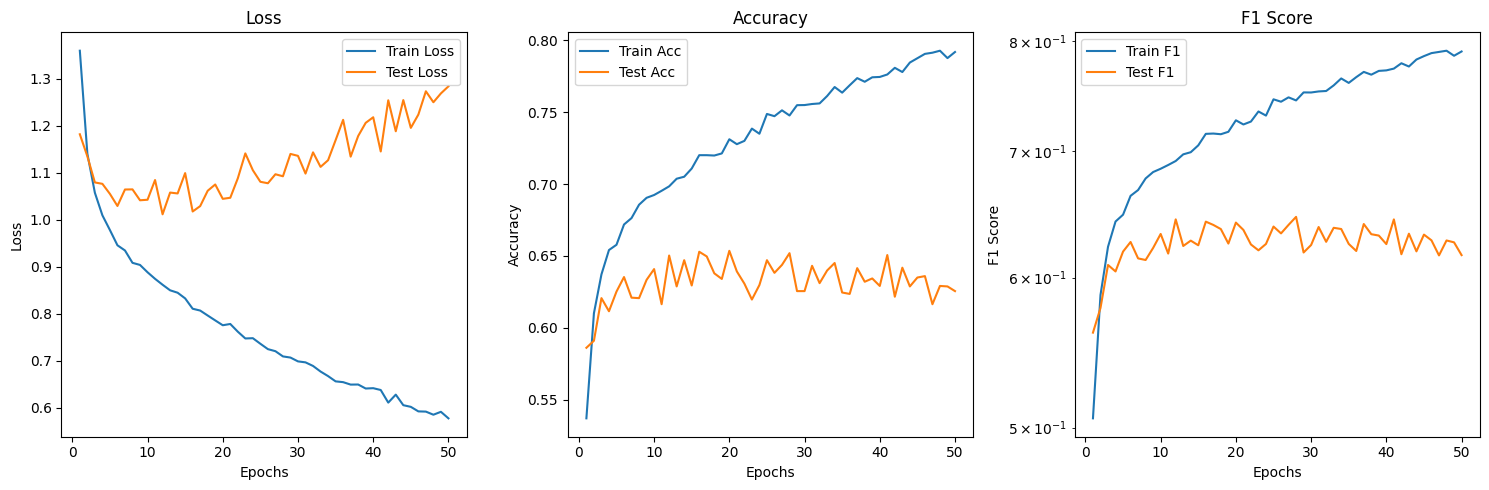

In [8]:
import torch.nn as nn
import torch.optim as optim
import torch as torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#создание простой модели
class SimpleFcModel(nn.Module):
    #инитиализация
    def __init__(self, num_classes, img_size):
        super().__init__()

        #присвоение размера картинок
        H, W = img_size
        input_dim = 1 * H * W
        self.flatten = nn.Flatten() #преобразование в вектор
        self.fc1 = nn.Linear(input_dim, 512) # линейный слой. На вход принимает набор чисел с размерностью 1* H * W. На выход отдает 512 параметров
        self.relu = nn.ReLU() #слой активатор. Все отрицательные числа приравнивает к 0, а положительные остаються положительными
        self.fc2 = nn.Linear(512, num_classes) #тоже самое. Только на вход принимает 512 парметров, а на выходе даёт num_classes(На выходе будут 7)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.relu(x)
        return x


#инициализируем размер изображения и саму модель
img_size = (100, 100)
model = SimpleFcModel(7, img_size).to(device)

 #добавляем оптимизаторы
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#переменные для кол-ва эпох и оценки
n_epoch = 50
best_f1 = 0.0

#история для создания графика
history = {
    "train_loss": [], "test_loss": [],
    "train_f1": [], "test_f1": [],
    "train_acc": [], "test_acc": []
}

#сам цикд обучения и цикл оценки
for epoch in range(n_epoch):
    print(f"\nEPOCH {epoch+1}/{n_epoch}")
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc, test_f1 = evaluate_epoch(model, test_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["train_f1"].append(train_f1)
    history["test_f1"].append(test_f1)
    history["train_acc"].append(train_acc)
    history["test_acc"].append(test_acc)

    if test_f1 > best_f1:
        best_f1 = test_f1
        best_epoch = epoch
        print(f"Epoch: {epoch+1}, F1: {best_f1:.3f}")

print(f"Best model: Epoch {best_epoch+1}, F1: {best_f1:.3f}")

#сохранение графика
plot_history(history)

Ответы на вопросы:
1.До flatten [32, 1, 100, 100]. После flatten[32, 10000]
На первом Linear in_features будет 10000. Число такое, потому что умножаеться количевстов каналов (1) на размер(100 * 100). Получаеться 10000
2. Я использовал nn.CrossEntropyLoss. Loss-- это показатель модели то, как плохо предсказывает, чем меньше этот показатель -- тем лучше модель справляеться с данными. Наша задача минимизировать loss, т.к. при его минимизации растёт процент точности модели. Loss можно плавно изменять, в то время как accyracy делает резкие скачки по графику.
3. Стоит оптимизатор Adam, а lr 1e-4.
Loss -- это потеря, которуюнужно минимизировать.
Градиент -- Минимизирует loss rate
Optimizer -- Адаптирует скорость обучения
Learning Rate -- контролирует шаг модели в оптимизации
4. Процесс переобучения начался между 10 и 20 жпохой, когда тестовые метрики начали хаотично падать и расти, в конце концов тестовая метрика находилась в приближенных значениях 60 - 63 процентов
5. Модель сохранила веса с 26 эпохи(не в ноутбуке модель сохранена с 13 эпохи). Веса с 50 эпохи к концу обучения падали и переучивались, в то время как веса с 8 эпохи остались лучшими, т.к. не подвергались переобучению.

Оценка модели(модель будет с папки models, лучшие метрики были в 13 эпохе)

In [9]:

model.load_state_dict(torch.load('../models/best_model_fc.pth', map_location=device))
model.eval()
model.to(device)

SimpleFcModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=10000, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=7, bias=True)
)

In [12]:
test_iter = iter(test_loader)
images, labels = next(test_iter)

with torch.no_grad():
    images = images.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

print(f"Форма входных данных: {images.shape}")
print(f"Предсказанные классы: {predicted.cpu().numpy()}")
print(f"Истинные классы: {labels.numpy()}")

Форма входных данных: torch.Size([32, 1, 100, 100])
Предсказанные классы: [0 0 0 0 3 3 3 0 6 0 6 0 0 0 0 0 0 6 2 0 0 0 0 0 0 0 5 6 0 6 0 0]
Истинные классы: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Батч загрузил все фотографии с папки 1. Модель предсказала папку с точностью 68,75(22/32).Модель путает удивление со счастьем, с нейтральным настроением, с отвращением и со злостью. 